In [1]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

In [1]:
train_file = '../data/next_day_wildfire_spread_train*'
validation_file = '../data/next_day_wildfire_spread_eval*'
test_file = '../data/next_day_wildfire_spread_test*'

In [3]:
def normalize_feature(feature, feature_name):
    """ Normalize features except 'PrevFireMask'. """
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    """ Parses TFRecord into tensors and normalizes features. """
    feature_description = {feat: tf.io.FixedLenFeature([64, 64], tf.float32) for feat in INPUT_FEATURES + OUTPUT_FEATURES}

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = [normalize_feature(tf.expand_dims(parsed_example[feat], -1), feat) for feat in INPUT_FEATURES]
    inputs = tf.concat(inputs_list, axis=-1)  # Convert to NumPy

    label = tf.expand_dims(parsed_example['FireMask'], -1)  # Shape: [64, 64, 1]
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label

In [4]:
import tensorflow as tf
def get_tensorflow_dataset(file_pattern):
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test datasets
train_numpy = get_tensorflow_dataset(train_file)
val_numpy = get_tensorflow_dataset(validation_file)
test_numpy = get_tensorflow_dataset(test_file)

In [5]:
import numpy as np
def convert_to_numpy(dataset):
    """ Convert TensorFlow dataset to NumPy arrays formatted for scikit-learn. """
    X, y = [], []
    for inputs, label in dataset:
        inputs = inputs.numpy()  # Convert to NumPy
        label = label.numpy()

        # Flatten from (64, 64, num_features) to (64*64, num_features)
        inputs = inputs.reshape(-1, inputs.shape[-1])
        label = label.reshape(-1)  # Flatten labels from (64, 64, 1) to (64*64,)

        X.append(inputs)
        y.append(label)

    # Concatenate all samples
    X = np.vstack(X)
    y = np.hstack(y)

    return X, y
X_train, y_train = convert_to_numpy(train_numpy)
X_val, y_val = convert_to_numpy(val_numpy)
X_test, y_test = convert_to_numpy(test_numpy)

In [6]:
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest classifier
rf_clf = RandomForestClassifier(
    n_estimators=10,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)
rf_clf.fit(X_train, y_train)

# Evaluate on validation set
val_accuracy = rf_clf.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.9866


AUC-ROC: 0.7346
AUC-PR: 0.0928


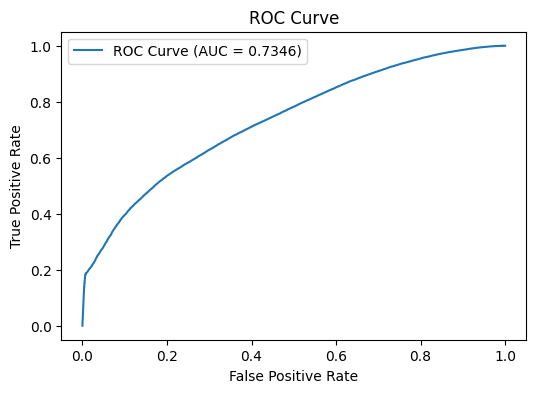

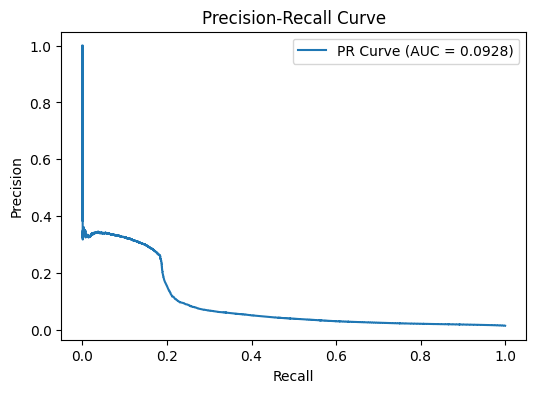

In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
# Get predicted probabilities for the positive class
y_val_probs = rf_clf.predict_proba(X_val)[:, 1]  # Get probability of class 1

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"AUC-ROC: {auc_roc:.4f}")

# Calculate AUC-PR
auc_pr = average_precision_score(y_val, y_val_probs)
print(f"AUC-PR: {auc_pr:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_roc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR Curve (AUC = {auc_pr:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()